In [1]:
# Python Imports
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Project Imports
from src.mesh_analysis.readers.file_reader import FileReader
from src.mesh_analysis.tracers.waku_tracer import WakuTracer
from src.mesh_analysis.visualizer.waku_visualizer import add_elapsed_time
from src.mesh_analysis.visualizer.waku_visualizer import prepare_dropdowns
from src.mesh_analysis.visualizer.waku_visualizer import get_node_position
from src.mesh_analysis.visualizer.waku_visualizer import display_msg_trace


In [2]:
tracer = WakuTracer()
# reader = FileReader("../../../deployment/local/logs_1000/", tracer)
reader = FileReader("../../../test/waku_simu3/log/", tracer)

df = reader.read()
df = add_elapsed_time(df)

interactive(children=(SelectMultiple(description='Msg hash', layout=Layout(height='100px', width='100%'), opti…

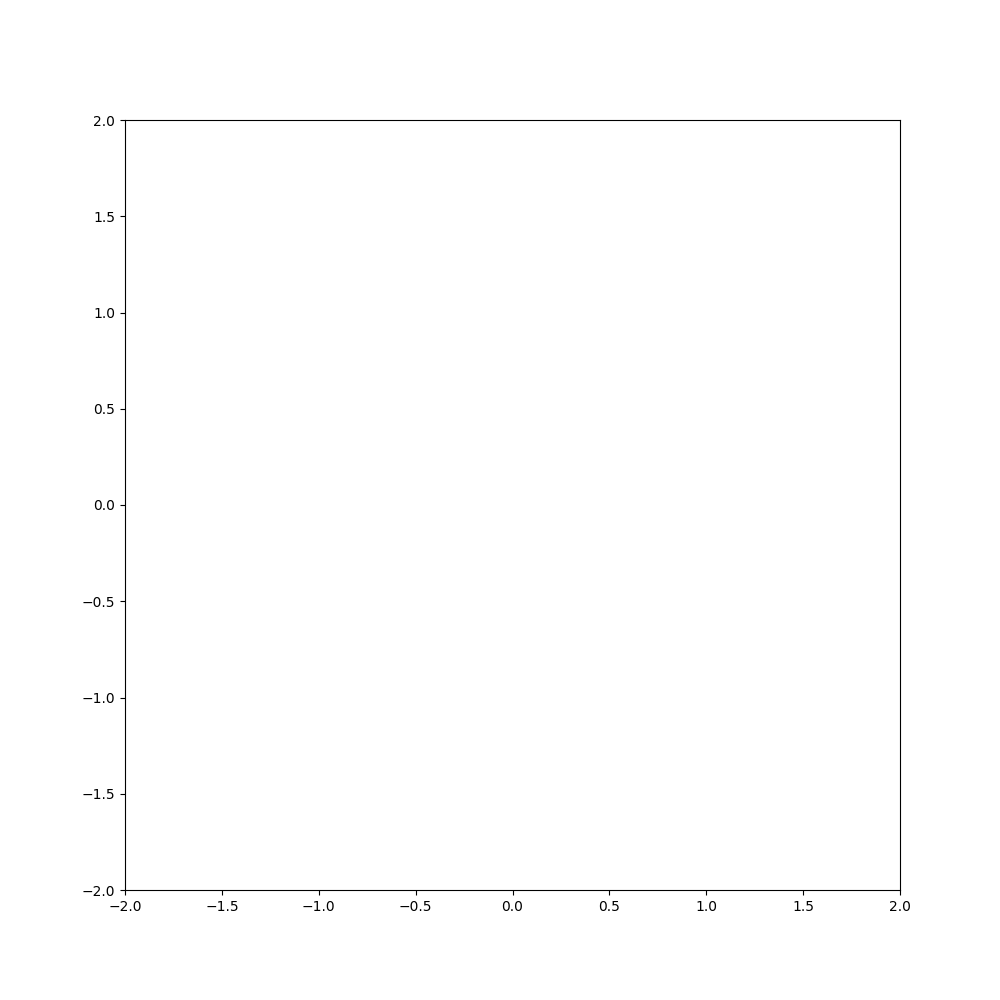

In [3]:
%matplotlib widget

msg_d, t_d, lookup = prepare_dropdowns(df)
g_pos_layout = get_node_position(df)
    
fig = plt.figure(figsize=(10,10))
ax_ = fig.add_subplot(1, 1, 1)

i_plot = widgets.interactive(display_msg_trace, x=msg_d, y=t_d, z=lookup, g_pos_layout=widgets.fixed(g_pos_layout),data_=widgets.fixed(df), ax_=widgets.fixed(ax_))
display(i_plot)

In [4]:
# Get missing messages (assuming no hash duplication)
missing = tracer.message_reliability("msg_hash", "receiver_peer_id", df)

All peers received all messages: False
Messages not received by all peers:
receiver_peer_id                                    16U*2gQsiA  16U*2jA6Qe  \
msg_hash                                                                     
0x0001d0aed4d6aeb7ab8ae8fbafb48580ee1eaecdf0c46...         7.0         6.0   
0x000a2a408d24721ddc1d984ba3d34a43264ef60653dc0...         4.0         3.0   
0x000fee14cfc38ec8fdf4efd8ef0dcb945fcedb8e08c82...         6.0         6.0   
0x00147f05ac81f2c3aaa95d249cb795ede30f604096f62...         5.0         5.0   
0x0016ea2a889843e67d1013e09d5a83237c912430baf36...         5.0         6.0   
...                                                        ...         ...   
0xffdc4c34effe02997b00dfe3e82b1ab61ee2e904312d5...         4.0         5.0   
0xffe18ad045938fa44d3c1cec0d5073f054627914faa6f...         5.0         5.0   
0xffe31452f0e7f7a3e74355397fb984e0c3c8ee3f1a217...         6.0         6.0   
0xfff181a5c99c2b2db740d07b931c6c8969f819849e1c6...         5.0     

In [5]:
# Get "slowest" messages
df[df['elapsed_time']==df['elapsed_time'].max()]

,,receiver_peer_id,sender_peer_id,elapsed_time
msg_hash,timestamp,,,
0xfa4b25cb3a06d3ddad2e62ddc53ed68d57de73290d08be4f18f33a147ceaa394,2024-06-18 16:59:21.670918400,16U*NYRCn4,16U*s3ZnL2,292303


In [6]:
# Get info of specific message hash
df.loc['0xfa4b25cb3a06d3ddad2e62ddc53ed68d57de73290d08be4f18f33a147ceaa394']

,receiver_peer_id,sender_peer_id,elapsed_time
timestamp,,,
2024-06-18 16:54:29.367713792,16U*mzB9q7,16U*APz559,0
2024-06-18 16:54:29.369057536,16U*GxbVM7,16U*APz559,1
2024-06-18 16:54:29.369135616,16U*GKP3ap,16U*APz559,1
2024-06-18 16:54:29.369737984,16U*BZVRbJ,16U*APz559,2
2024-06-18 16:54:29.369893632,16U*96MwUq,16U*APz559,2
...,...,...,...
2024-06-18 16:59:17.583878400,16U*myqvtc,16U*2jA6Qe,288216
2024-06-18 16:59:17.585338624,16U*myqvtc,16U*66ufrC,288217
2024-06-18 16:59:18.248192000,16U*Vsjsg2,16U*96MwUq,288880


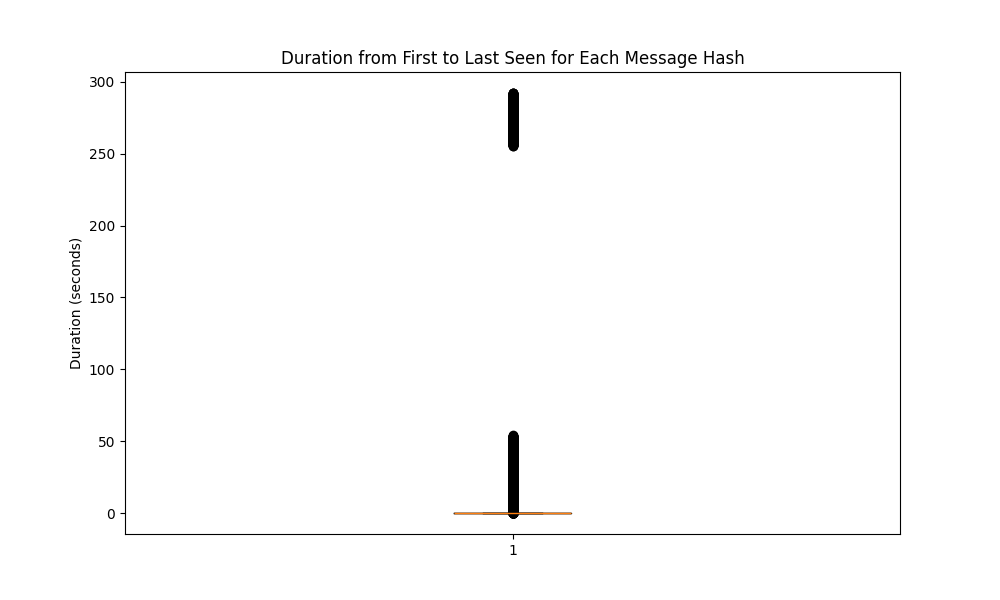

In [7]:
# Calculates delivery message time distribution
duration_df = df.groupby('msg_hash').apply(lambda x: x.index.get_level_values('timestamp').max() - x.index.get_level_values('timestamp').min())
duration_df = duration_df.reset_index()
duration_df.columns = ['message_hash', 'duration']

plt.figure(figsize=(10, 6))
plt.boxplot(duration_df['duration'].dt.total_seconds()) 
plt.ylabel('Duration (seconds)')
plt.title('Duration from First to Last Seen for Each Message Hash')
plt.show()